# Goal: Calculate $A_{sym}$ for different energy thresholds or energy bins

This is a very simple and straightforward way of demonstrating that higher energy neutrons experience stronger anisotropy. 

We will calculate the magnitude of anisotropy as a one-dimensional parameter as:

$$A_{sym} = \frac{W(180^\circ)}{W(90^\circ)}$$

This is the same method as Tony Shin is using in his multiplicity counter work, and the same method that several previous papers have used. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style='ticks')

In [4]:
sys.path.append('../scripts/')

In [5]:
import bicorr as bicorr
import bicorr_plot as bicorr_plot
import bicorr_sums as bicorr_sums
import bicorr_math as bicorr_math

In [6]:
%load_ext autoreload
%autoreload 2

# Load the data

According to the method I laid out at the end of `singles_correction.ipynb`, I need to load the following data:

* det_df
* dict_index_to_det
* singles_hist
* dt_bin_edges_sh
* bhp_nn_pos
* bhp_nn_neg
* dt_bin_edges
* emin
* emax
* num_fissions
* angle_bin_edges

I will work with the data from the combined data sets in `analysis\Cf072115_to_Cf072215b`.

In [7]:
det_df = bicorr.load_det_df('../meas_info/det_df_pairs_angles.csv', remove_fc_neighbors = True)

In [8]:
singles_hist, dt_bin_edges_sh, dict_det_to_index, dict_index_to_det = bicorr.load_singles_hist(filepath='../analysis/Cf072115_to_Cf072215b/datap')

In [11]:
npzfile = np.load('../analysis_no_Ethresh_with_CT\Cf072115_to_Cf072215b\datap/bhp_nn_by_pair_1ns.npz')
bhp_nn_pos = npzfile['bhp_nn_pos']
bhp_nn_neg = npzfile['bhp_nn_neg']
dt_bin_edges = npzfile['dt_bin_edges']

`emin`, `emax` will be input parameters. I will vary `emin`.

In [12]:
num_fissions = 2194651200.00
angle_bin_edges = np.arange(8,190,10)

# Calculate $A_{sym}$ in a given energy range

Use the all-in-one function for calculating `singles_df`, `det_df`, and `by_angles_df` in one step: `bicorr_sums.perform_W_calcs`.
Look at what has been our default energy range.

## Produce all of the relevant dataframes

In [13]:
emin = .62
emax = 12

The code will produce the sum across energy ranges that are rounded down from these values to find the bin edges. Where should I get them back from?

Add optional flag to return `energies_real`. This way it won't break all my old notebooks. Note that energies_real is `[emax_real,emin_real]`.

In [14]:
singles_df, det_df, by_angle_df, energies_real = bicorr_sums.perform_W_calcs(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, emin, emax, angle_bin_edges, return_real_energies_flag = True)
print(energies_real)

Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
[11.06075605267042, 0.6092398950294307]


## Store information at $180^\circ$ and $90^\circ$

Find the bins in `by_angle_df` that contain $180^\circ$ and $90^\circ$.

In [15]:
angle_bin_edges

array([  8,  18,  28,  38,  48,  58,  68,  78,  88,  98, 108, 118, 128,
       138, 148, 158, 168, 178, 188])

In [16]:
series_180 = by_angle_df.loc[np.int(np.digitize(180,angle_bin_edges))-1]

In [17]:
series_90 = by_angle_df.loc[np.int(np.digitize(90,angle_bin_edges))-1]

In [18]:
series_180['W']/series_90['W']

1.5256757291319993

In [27]:
series_min = by_angle_df.loc[by_angle_df['W'].idxmin()]

In [28]:
num = series_180['W']
num_err = series_180['W_err']
denom = series_90['W']
denom_err = series_90['W_err']
minval = series_min['W']
minval_err = series_min['W_err']

Asym, Asym_err = bicorr_math.prop_err_division(num,num_err,denom,denom_err)
Asym_min, Asym_min_err = bicorr_math.prop_err_division(num,num_err,minval,minval_err)

In [29]:
print(Asym, Asym_err)
print(Asym_min, Asym_min_err)

1.5256757291319993 0.004752114234078003
1.5400287721476393 0.004810807437898669


## Functionalize this

In [30]:
bicorr_sums.calc_Asym(by_angle_df)

(1.5256757291319993, 0.044588166954664256)

In [32]:
bicorr_sums.calc_Asym(by_angle_df, min_flag=True)

(1.5256757291319993,
 0.044588166954664256,
 1.5400287721476393,
 0.03874994925734614)

# Calculate for variable `emin`

## Create `Asym_df` for storing results

Create a dataframe for storing these values, because I like dataframes now. 

In [33]:
emins = np.arange(0.5,5,.2)
print(emins)
emax = 12

[0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9
 4.1 4.3 4.5 4.7 4.9]


In [34]:
Asym_df = pd.DataFrame(data = emins, columns = {'emin'})
Asym_df['emax'] = emax
Asym_df['Asym'] = np.nan
Asym_df['Asym_err'] = np.nan
Asym_df['Asym_min'] = np.nan
Asym_df['Asym_min_err'] = np.nan

In [35]:
Asym_df.head()

,emin,emax,Asym,Asym_err,Asym_min,Asym_min_err
0,0.5,12,NaN,NaN,NaN,NaN
1,0.7,12,NaN,NaN,NaN,NaN
2,0.9,12,NaN,NaN,NaN,NaN
3,1.1,12,NaN,NaN,NaN,NaN
4,1.3,12,NaN,NaN,NaN,NaN


## Fill `Asym_df`

In [36]:
for index, row in Asym_df.iterrows():    
    singles_df, det_df, by_angle_df = bicorr_sums.perform_W_calcs(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, row['emin'], row['emax'], angle_bin_edges)
    Asym, Asym_err, Asym_min, Asym_min_err = bicorr_sums.calc_Asym(by_angle_df,min_flag=True)
    
    Asym_df.loc[index,'Asym'] = Asym
    Asym_df.loc[index,'Asym_err'] = Asym_err
    Asym_df.loc[index,'Asym_min'] = Asym_min
    Asym_df.loc[index,'Asym_min_err'] = Asym_min_err
    

Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 

Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angl

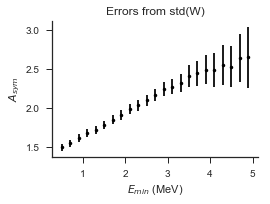

In [37]:
plt.figure(figsize=(4,3))
plt.errorbar(Asym_df['emin'],Asym_df['Asym'],yerr=Asym_df['Asym_err'],fmt='.',color='k')
plt.xlabel('$E_{min}$ (MeV)')
plt.ylabel('$A_{sym}$')
plt.title('Errors from std(W)')
sns.despine(right=True)
bicorr_plot.save_fig_to_folder('Asym_vs_angle_std_W')
plt.show()

If instead I want to propagate errors from `W_err` (statistical error):

In [39]:
for index, row in Asym_df.iterrows():    
    singles_df, det_df, by_angle_df = bicorr_sums.perform_W_calcs(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, row['emin'], row['emax'], angle_bin_edges)
    Asym, Asym_err, Asym_min, Asym_min_err = bicorr_sums.calc_Asym(by_angle_df,std_flag=True,min_flag=True)
    
    Asym_df.loc[index,'Asym'] = Asym
    Asym_df.loc[index,'Asym_err'] = Asym_err
    Asym_df.loc[index,'Asym_min'] = Asym_min
    Asym_df.loc[index,'Asym_min_err'] = Asym_min_err

Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 

Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angl

## Plot, save figure

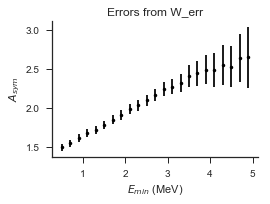

In [40]:
plt.figure(figsize=(4,3))
plt.errorbar(Asym_df['emin'],Asym_df['Asym'],yerr=Asym_df['Asym_err'],fmt='.',color='k')
plt.xlabel('$E_{min}$ (MeV)')
plt.ylabel('$A_{sym}$')
plt.title('Errors from W_err')
sns.despine(right=True)
bicorr_plot.save_fig_to_folder('Asym_vs_angle_W_err')
plt.show()

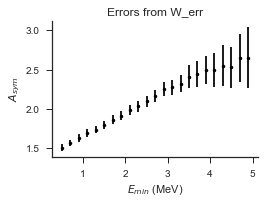

In [41]:
plt.figure(figsize=(4,3))
plt.errorbar(Asym_df['emin'],Asym_df['Asym_min'],yerr=Asym_df['Asym_min_err'],fmt='.',color='k')
plt.xlabel('$E_{min}$ (MeV)')
plt.ylabel('$A_{sym}$')
plt.title('Errors from W_err')
sns.despine(right=True)
bicorr_plot.save_fig_to_folder('Asym_min_vs_angle_W_err')
plt.show()

## Functionalize this

Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 

Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angle bin 18 to 28
Generating data in angle bin 28 to 38
Generating data in angle bin 38 to 48
Generating data in angle bin 48 to 58
Generating data in angle bin 58 to 68
Generating data in angle bin 68 to 78
Generating data in angle bin 78 to 88
Generating data in angle bin 88 to 98
Generating data in angle bin 98 to 108
Generating data in angle bin 108 to 118
Generating data in angle bin 118 to 128
Generating data in angle bin 128 to 138
Generating data in angle bin 138 to 148
Generating data in angle bin 148 to 158
Generating data in angle bin 158 to 168
Generating data in angle bin 168 to 178
Generating data in angle bin 178 to 188
Generating data in angle bin 8 to 18
Generating data in angl

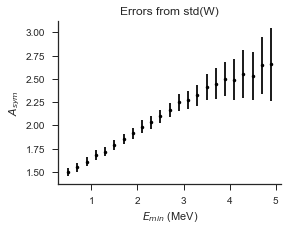

,emin,emax,emin_real,emax_real,Asym,Asym_err
0,0.5,12,0.492479,11.060756,1.497403,0.043949
1,0.7,12,0.691297,11.060756,1.548867,0.044380
2,0.9,12,0.891806,11.060756,1.612529,0.052050
3,1.1,12,1.097981,11.060756,1.678189,0.053859
4,1.3,12,1.265385,11.060756,1.719717,0.051153


In [42]:
Asym_df = bicorr_sums.calc_Asym_vs_emin(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, emins, emax, angle_bin_edges,
                    plot_flag=True, save_flag=False)
Asym_df.head()

I'm updating this to return `emin_real` and `emax_real`, which are slightly different than `emin` and `emax` due to discrete binning. 

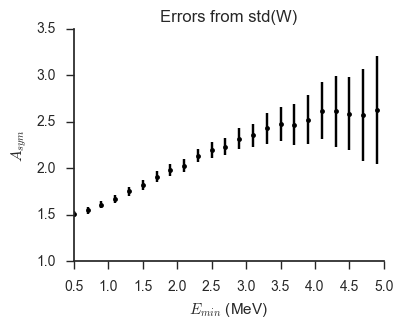

,emin,emax,emin_real,emax_real,Asym,Asym_err
0,0.5,12,0.495313,11.915599,1.502363,0.033244
1,0.7,12,0.694250,11.915599,1.545859,0.035890
2,0.9,12,0.886284,11.915599,1.604191,0.038897
3,1.1,12,1.072404,11.915599,1.668908,0.042293
4,1.3,12,1.282905,11.915599,1.749523,0.046560


In [32]:
Asym_df = bicorr_sums.calc_Asym_vs_emin(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, emins, emax, angle_bin_edges,
                    plot_flag=True, save_flag=False)
Asym_df.head()

# Calculate for variable `ebin`

Instead of varying energy threshold, only select events within a given energy bin, bound by emin, emax.

The only thing I really need to change is how I initialize `Asym_df`.

In [13]:
e_bin_edges = np.arange(0.5,5,.2)

In [17]:
Asym_df = pd.DataFrame(data = {'emin':e_bin_edges[:-1],'emax':e_bin_edges[1:]})
Asym_df.head()

,emax,emin
0,0.7,0.5
1,0.9,0.7
2,1.1,0.9
3,1.3,1.1
4,1.5,1.3


I updated this method in a new function called `bicorr_sums.calc_Asym_vs_ebin`. The rest of the function is the same as `calc_Asym_vs_emin`.

../scripts\bicorr_math.py:28: RuntimeWarning: invalid value encountered in double_scalars
  A = num/denom
../scripts\bicorr_math.py:30: RuntimeWarning: invalid value encountered in double_scalars
  A_err = A*np.sqrt((num_err/num)**2+(denom_err/denom)**2)


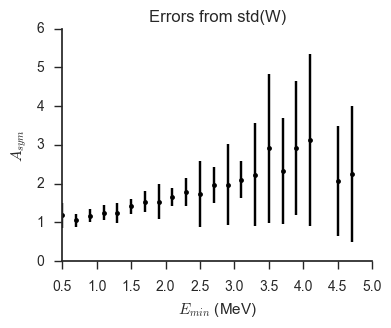

,emax,emin,Asym,Asym_err
0,0.7,0.5,1.174629,0.331594
1,0.9,0.7,1.050754,0.167779
2,1.1,0.9,1.172604,0.167299
3,1.3,1.1,1.243500,0.190377
4,1.5,1.3,1.243286,0.257328


In [20]:
Asym_df = bicorr_sums.calc_Asym_vs_ebin(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, e_bin_edges, angle_bin_edges,
                    plot_flag=True, save_flag=False)
Asym_df.head()